# Overfitting and Regularization

## Imports

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [118]:
set_config(display='diagram')

## Settings

In [119]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [120]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

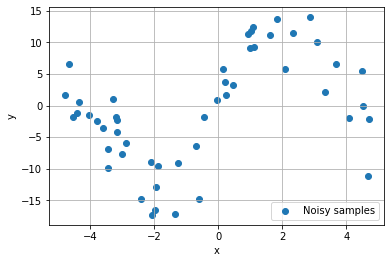

In [121]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

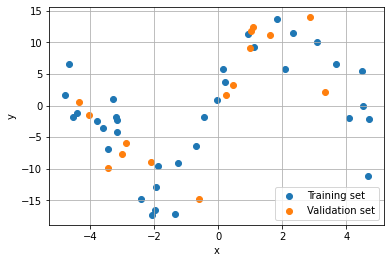

In [122]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [123]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [124]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [125]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

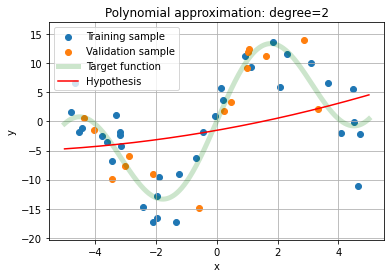

In [126]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

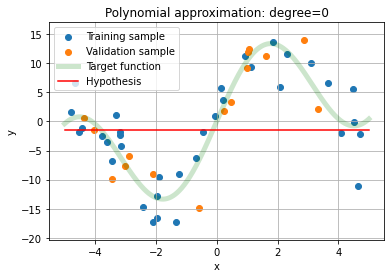

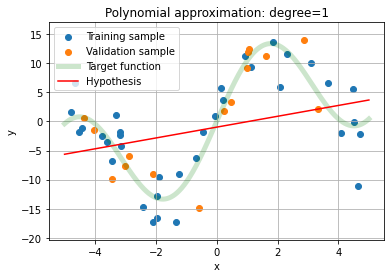

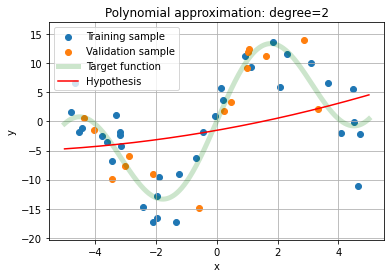

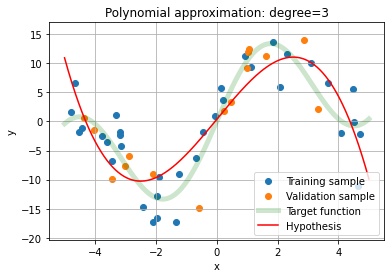

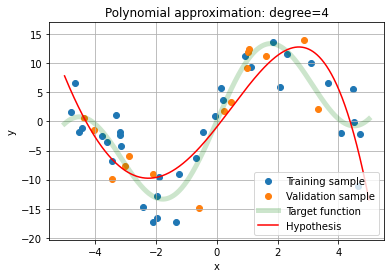

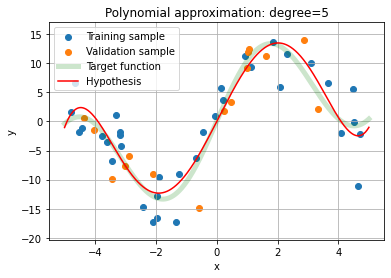

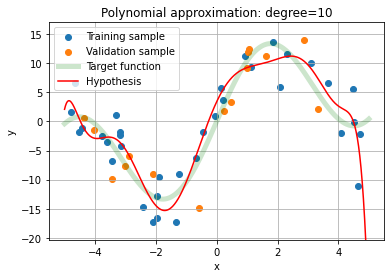

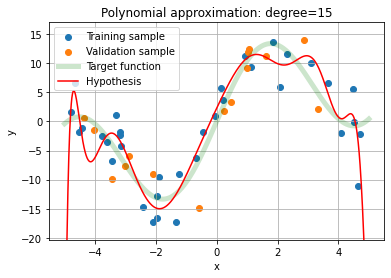

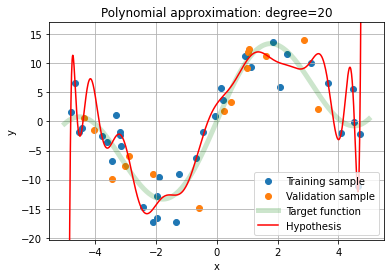

In [127]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

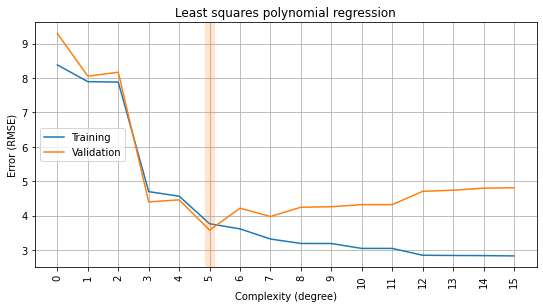

In [128]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [129]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

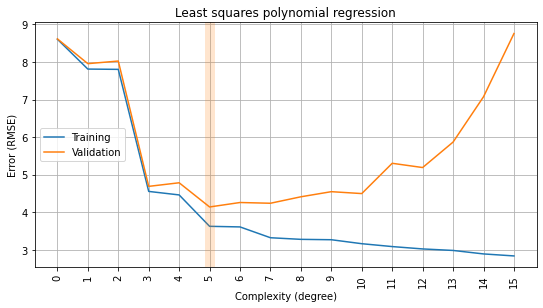

In [130]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [131]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

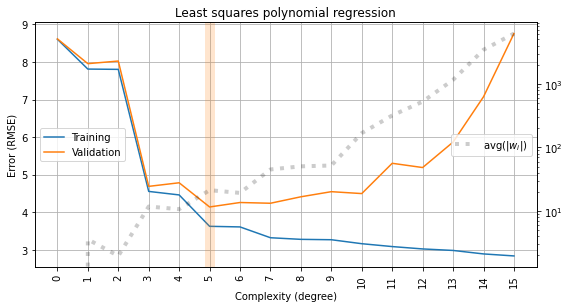

In [132]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

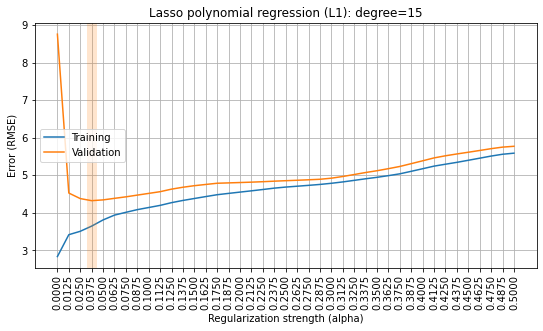

In [133]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

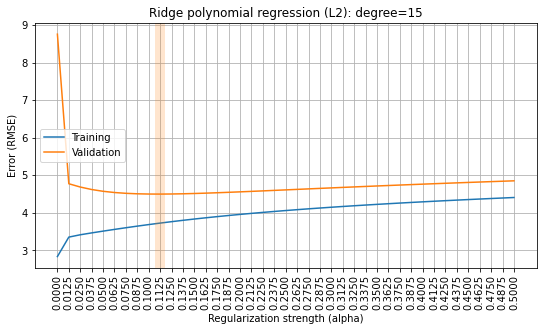

In [134]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [135]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

- We will create polynomial features of different degrees only for last 5 features subset, due to the limited power of machine. 
- Our data has already been scaled.  
Let's redefine make_model function:

In [136]:
from sklearn.compose import ColumnTransformer

features_to_poly = X_diabetes.columns[5:].tolist()
features_initial = X_diabetes.columns[:5].tolist()

def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    ct = ColumnTransformer([
            ('poly_transform', PolynomialFeatures(degree, include_bias=(degree == 0)), features_to_poly),
            ('no_transform', PolynomialFeatures(1, include_bias=False), features_initial)
        ])

    return Pipeline([
            ('ct', ct),
            ('reg', regressor)
        ])

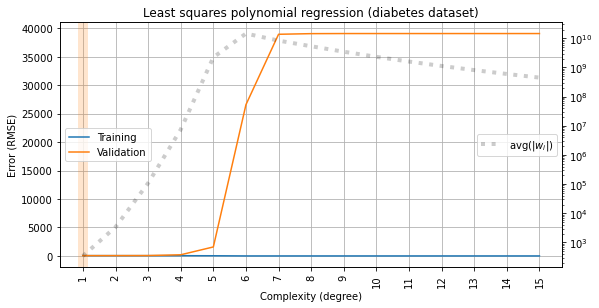

In [137]:
rmse_train, rmse_valid, avg_coef = [], [], []
mape_train, mape_valid = [], []

for degree in DEGREES[1:]:
    results = cross_validate(make_model(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error'])
    
    rmse_train.append(-np.mean(results['train_neg_root_mean_squared_error']))
    rmse_valid.append(-np.mean(results['test_neg_root_mean_squared_error']))

    mape_train.append(-np.mean(results['train_neg_mean_absolute_percentage_error']))
    mape_valid.append(-np.mean(results['test_neg_mean_absolute_percentage_error']))
    
    avg_coef.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
plot_fitting_graph(DEGREES[1:], rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression (diabetes dataset)')

In [138]:
pd.DataFrame({'rmse_train': rmse_train, 'rmse_valid': rmse_valid}, index=DEGREES[1:])

,rmse_train,rmse_valid
1,5.334147e+01,54.691714
2,5.166148e+01,55.611926
3,4.922542e+01,66.200228
4,4.415415e+01,202.595037
5,3.021722e+01,1579.985575
6,4.126859e-09,26591.121214
7,3.342076e-09,38964.962447
8,3.231553e-09,39076.428978
9,4.109796e-09,39092.836869
10,4.372061e-09,39093.331887


We get the smallest validation error value using degree = 1 (initial features without polynomial feature engineering) and wee see very large validation errors after degree 5.  
Let's have a closer look to smaller degrees:

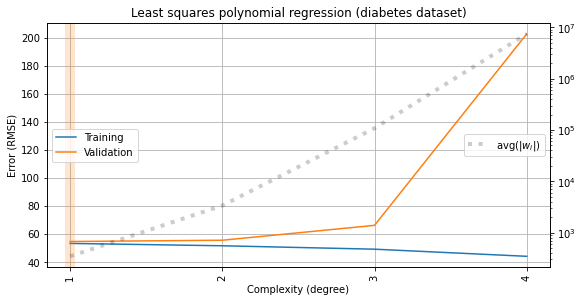

In [139]:
plot_fitting_graph(DEGREES[1:5], rmse_train[:4], rmse_valid[:4],
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef[:4], custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression (diabetes dataset)')

### Conclusion:
We get the smallest validation error on **degree = 1** (initial feature set without polynomial feature engineering). Both errors are relatively small and close to each other, which means that fit with degree = 1 is **just right**.   
With **degree > 1** model starts **overfit** (train error gets better, but validation error gets worse).  The difference between errors is not so big for degrees 2 and 3, but it gets bigger and bigger with higher degrees.  
Model coefficients take on larger values as degree increases.

Just in case, let's have a look on MAPE error:

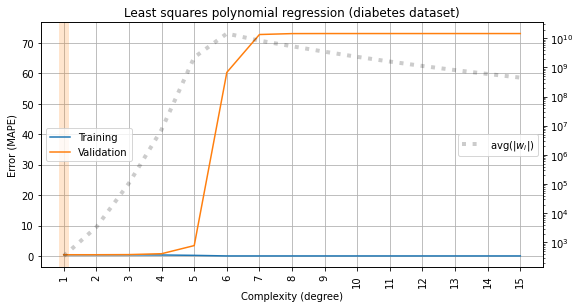

In [140]:
plot_fitting_graph(DEGREES[1:], mape_train, mape_valid,
                   xlabel='Complexity (degree)', ylabel='Error (MAPE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression (diabetes dataset)')

We see that picture is similar.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

- To find out how weights change with regularization we will plot the mean absolute value of weights as a function of alpha:

In [141]:
def plot_weights(alphas, weights_l1, weights_l2, label_1, label_2, xlabel, ylabel, title):
    plt.figure(figsize=(9, 4.5))
    if len(weights_l1) != 0:
        plt.plot(alphas, weights_l1, label=label_1)
    if len(weights_l2) != 0:
        plt.plot(alphas, weights_l2, label=label_2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(alphas, rotation='vertical')
    plt.legend()
    plt.show()

#### L1

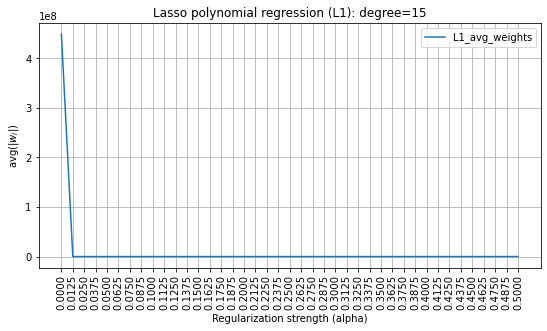

In [142]:
avg_coef_l1 = []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    
    avg_coef_l1.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
plot_weights(ALPHAS, weights_l1=avg_coef_l1, weights_l2=[],
            label_1='L1_avg_weights', label_2='', 
            xlabel='Regularization strength (alpha)', ylabel='avg(|$w_i$|)',
            title='Lasso polynomial regression (L1): degree=15')

In [143]:
pd.DataFrame(avg_coef_l1, index=ALPHAS, columns=['avg_coef_l1'])

,avg_coef_l1
0.0000,4.488394e+08
0.0125,2.032131e-01
0.0250,1.364183e-01
0.0375,1.279176e-01
0.0500,1.235797e-01
0.0625,1.202083e-01
0.0750,1.173387e-01
0.0875,1.145075e-01
0.1000,1.116761e-01
0.1125,1.090023e-01


Indeed, we see that mean of absolute weights gets smaller with increase of alpha. Alpha = 0 corresponds to simple LinearRegression model (and we see that avg(|$w_i$|) is enormous due to degree = 15). Let's drop it to get a clearer visualization:

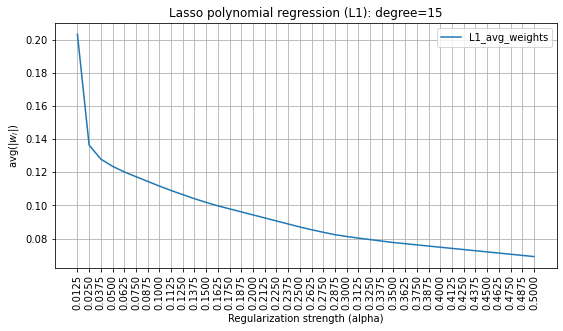

In [144]:
plot_weights(ALPHAS[1:], weights_l1 = avg_coef_l1[1:], weights_l2=[], 
            label_1='L1_avg_weights', label_2='',
            xlabel='Regularization strength (alpha)', ylabel='avg(|$w_i$|)',
            title='Lasso polynomial regression (L1): degree=15')

Now we see clearly that larger alphas constraint weights more.

#### L2

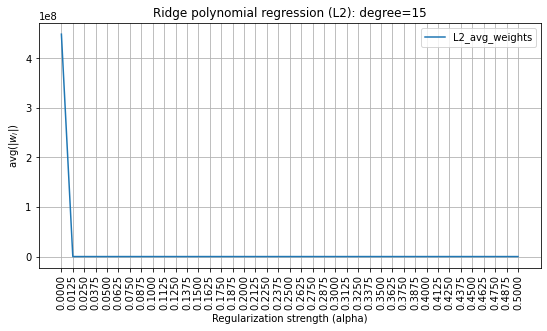

In [145]:
avg_coef_l2 = []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    
    avg_coef_l2.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
plot_weights(ALPHAS, weights_l1=[], weights_l2=avg_coef_l2,
            label_1='', label_2='L2_avg_weights',
            xlabel='Regularization strength (alpha)', ylabel='avg(|$w_i$|)',
            title='Ridge polynomial regression (L2): degree=15')

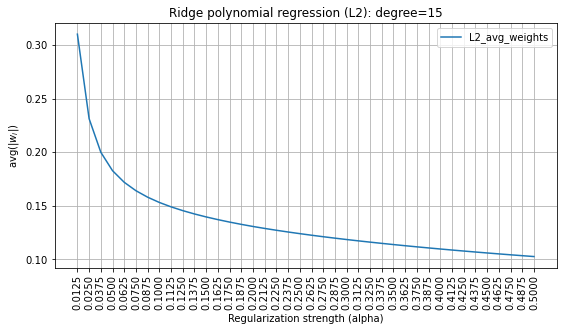

In [146]:
plot_weights(ALPHAS[1:], weights_l1=[], weights_l2=avg_coef_l2[1:], 
            label_1='', label_2='L2_avg_weights',
            xlabel='Regularization strength (alpha)', ylabel='avg(|$w_i$|)',
            title='Ridge polynomial regression (L2): degree=15')

Let's visualize both curves on the same graph:

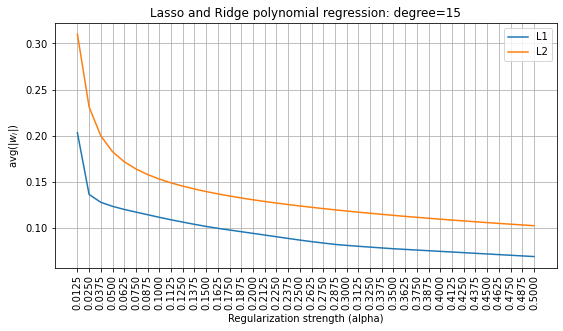

In [147]:
plot_weights(ALPHAS[1:],  weights_l1=avg_coef_l1[1:], weights_l2=avg_coef_l2[1:],
            label_1='L1', label_2='L2',
            xlabel='Regularization strength (alpha)', ylabel='avg(|$w_i$|)',
            title='Lasso and Ridge polynomial regression: degree=15')

#### Summary

We see clearly that regularization methods constraint the weights.  

Overfitted and too complex models tend to have large weights and regularization is a good way dealing with overfitting because it forces model coefficients to be smaller in magnitude (large weights are bad because small changes in predictor variables cause huge changes in target, that makes our model unstable).  

avg(|$w_i$|) gets smaller with higher alphas, which makes sense:  
Lasso (Ridge) regression minimizes following expression: **the sum of squared residuals + λ * the slope (the slope^2)**  
Second term of expression adds a penalty to the traditional Least Squares method and alpha(lambda) determines how severe that penalty is. For large alpha values, the optimal solution to minimize our expression would be to set weights close to zero.
 
We see on the last graph that avg(|$w_i$|) is less with L1 than with L2. This is because of the fact that L1 is more likely to produce zero coefficients, which we will consider in more detail in the next task.  
Another interseting observation, that curve of L2-weights is smoother (why? For now, I haven't found a good explanation for this, but if you check my work and know the answer, please contact me at discord :)) 

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

- To find out if L1 more likely to produce zero coefficients we will count and plot number of zero(non-zero) weights as a function of alpha.  
We won't use cross-validation in this task for the sake of simplicity (in order not to average the number of zero weights over each cv fold):

#### L1

In [148]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

Total number of weights: 15508


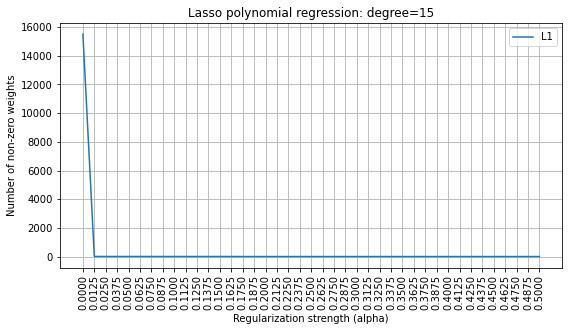

In [149]:
number_of_zero_weights, number_of_nonzero_weights = [], []
selected_features = []
for alpha in ALPHAS:
    pipe = make_model(degree=15, penalty='L1', alpha=alpha).fit(X_train, y_train)
    number_of_zero_weights.append(np.count_nonzero(pipe.named_steps['reg'].coef_==0))
    number_of_nonzero_weights.append(np.count_nonzero(pipe.named_steps['reg'].coef_))
    df = pd.DataFrame(pipe.named_steps['reg'].coef_.T, index=pipe.named_steps['ct'].get_feature_names_out(), columns=['coef'])
    selected_features.append(df[df['coef']!=0])

print(f'Total number of weights: {len(pipe.named_steps["reg"].coef_)}')    
plot_weights(ALPHAS, weights_l1=number_of_nonzero_weights, weights_l2=[],
            label_1='L1', label_2='',
            xlabel='Regularization strength (alpha)', ylabel='Number of non-zero weights',
            title='Lasso polynomial regression: degree=15')

Alpha = 0 corresponds to simple LinearRegression model and all features take non-zero values. Let's drop it to get a clearer visualization:

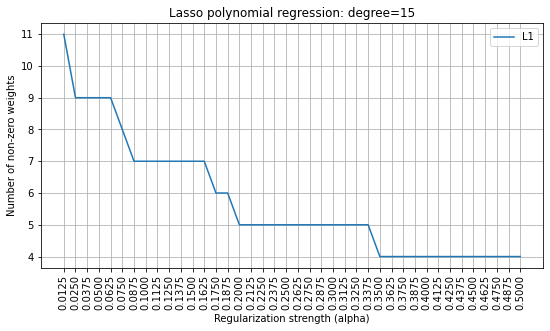

In [150]:
plot_weights(ALPHAS[1:], weights_l1=number_of_nonzero_weights[1:], weights_l2=[],
            label_1='L1', label_2='',
            xlabel='Regularization strength (alpha)', ylabel='Number of non-zero weights',
            title='Lasso polynomial regression: degree=15')

We see that L1 immediately shrinks number of non-zero weights from 15508 to 11. Does it correspond to our initial feature set? Let's have a look:

In [151]:
display(selected_features[1])

,coef
poly_transform__s2,127.859636
poly_transform__s3,-94.921995
poly_transform__s4,205.336208
poly_transform__s5,473.576962
poly_transform__s6,24.830924
poly_transform__s6^2,863.828082
no_transform__age,32.778120
no_transform__sex,-249.617992
no_transform__bmi,558.904561
no_transform__bp,381.350987


We see that all initial features remained among the selected ones and there is one additional transformed feature (s6^2). But weights are still quite high due to the complexity of our model (degree = 15).   
Which features are selected with the highest alpha?

In [152]:
display(selected_features[-1])

,coef
poly_transform__s3,-107.850780
poly_transform__s5,289.354267
no_transform__bmi,527.759899
no_transform__bp,193.153794


All selected features belong to initial ones. It means that there was no sense to add polynomial features and this is consistent with our findings from task 1 (optimal degree = 1 and it is just initial features without polynomial feature engineering).

#### L2

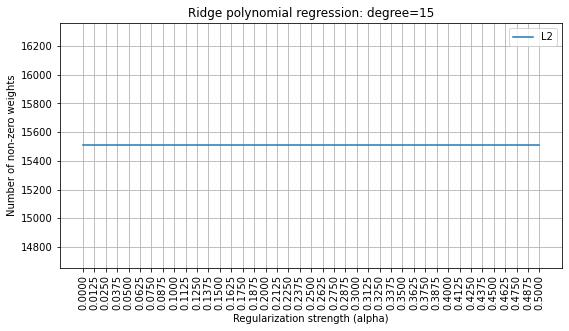

In [153]:
number_of_zero_weights, number_of_nonzero_weights = [], []
for alpha in ALPHAS:
    pipe = make_model(degree=15, penalty='L2', alpha=alpha).fit(X_train, y_train)
    number_of_zero_weights.append(np.count_nonzero(pipe.named_steps['reg'].coef_==0))
    number_of_nonzero_weights.append(np.count_nonzero(pipe.named_steps['reg'].coef_))
   
plot_weights(ALPHAS, weights_l1=[], weights_l2=number_of_nonzero_weights,
            label_1='', label_2='L2',
            xlabel='Regularization strength (alpha)', ylabel='Number of non-zero weights',
            title='Ridge polynomial regression: degree=15')

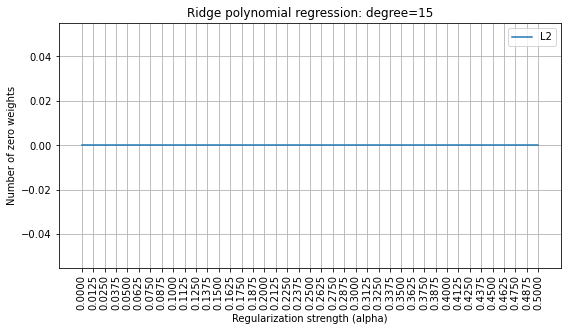

In [154]:
plot_weights(ALPHAS, weights_l1=[], weights_l2=number_of_zero_weights,
            label_1='', label_2='L2',   
            xlabel='Regularization strength (alpha)', ylabel='Number of zero weights',
            title='Ridge polynomial regression: degree=15')

Indeed, we see that with L2 regularization number of zero weights equals zero for any alpha.

#### Summary

We saw that Lasso regularization more likely to produce zero coefficients and can be used for feature selection. This is especially convenient when we have a lot of useless features.   
With Ridge regularization weights shift towards zero but never equal to zero.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [155]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


We see that features have different scales.  
We will redefine make_model function so that it accepts the new parameter **scale=True/False**:

In [156]:
def make_model(degree, alpha=0, penalty=None, scale=False):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    if scale:
        return Pipeline([
            ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
            ('sca', StandardScaler()),
            ('reg', regressor)
        ])
    return Pipeline([
            ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
            ('reg', regressor)
        ])

Define function for plotting weights:

In [157]:
def plot_weights_for_each_feature(alphas, weights, xlabel, ylabel, title):
    plt.figure(figsize=(9, 4.5))
    for i in range(weights.shape[1]):
        plt.plot(alphas, weights.iloc[:, i].values, label=weights.columns[i])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(alphas, rotation='vertical')
    plt.legend()
    plt.show()

To find out how scaling affects regularization we will plot features weights (scaled and non-scaled) as a function of alpha:

#### L1

Firstly, let's discover change in weights with non-scaled input features:

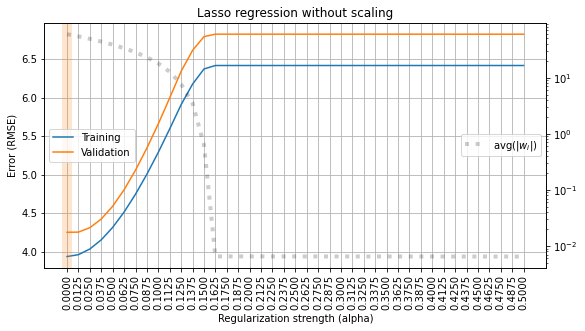

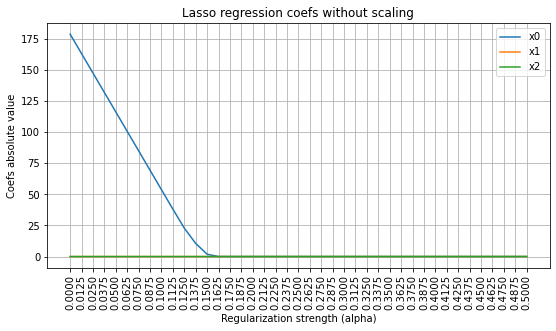

In [158]:
rmse_train, rmse_valid, coefs, avg_coef = [], [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha, scale=False), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    
    
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
    # average weight over cv folds for each feature
    n_features = results['estimator'][-1]['pol'].n_output_features_
    coefs.append([np.mean([np.abs(model['reg'].coef_[i]) for model in results['estimator']]) for i in range(n_features)])
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso regression without scaling')

coefs = np.array(coefs)
columns = results['estimator'][-1]['pol'].get_feature_names_out()
coefs_df = pd.DataFrame(coefs, columns=columns, index=ALPHAS)
coefs_df.index.name = 'alpha'                 
plot_weights_for_each_feature(ALPHAS, coefs_df, 
                                  xlabel='Regularization strength (alpha)', ylabel='Coefs absolute value', 
                                  title='Lasso regression coefs without scaling')

In [159]:
coefs_df

,x0,x1,x2
alpha,,,
0.0000,178.952210,0.000807,0.011952
0.0125,163.309329,0.000872,0.012504
0.0250,147.666492,0.000938,0.013055
0.0375,132.023656,0.001003,0.013606
0.0500,116.380819,0.001069,0.014157
0.0625,100.737983,0.001134,0.014709
0.0750,85.095146,0.001200,0.015260
0.0875,69.452592,0.001276,0.015811
0.1000,53.809798,0.001389,0.016363


We see that weights of first feature significantly differ from other weights at the very beginning. We may mistakenly conclude that this indicates the importance of first feature, although in fact this is only due to the strong difference in the scales between the first feature (which takes values in the range [-0.05, 0.05]) and the others (which take values in the range [-494.87, 493.57] and [-2.35, 213.31] correspondingly).  
Let's have a closer look to change in weights of second and third features: 

In [160]:
# plot_weights_for_each_feature(ALPHAS[13:], coefs_df.iloc[13:, :], 
#                                   xlabel='Regularization strength (alpha)', ylabel='Coefs absolute value', 
#                                   title='Lasso regression coefs without scaling')

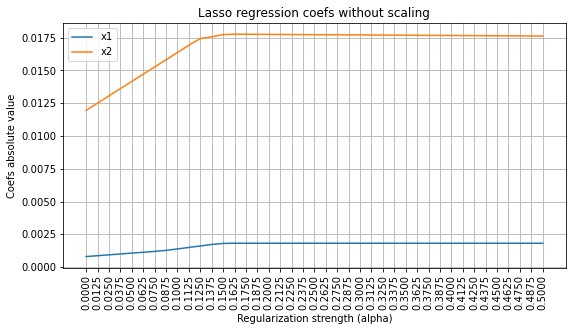

In [161]:
plot_weights_for_each_feature(ALPHAS, coefs_df.iloc[:, 1:], 
                                  xlabel='Regularization strength (alpha)', ylabel='Coefs absolute value', 
                                  title='Lasso regression coefs without scaling')

They take very small (almost zero values) but increase with alpha, which contradicts our conclusion from the second task (regularization constraints weights).

Let's discover change in weights with scaled input features:

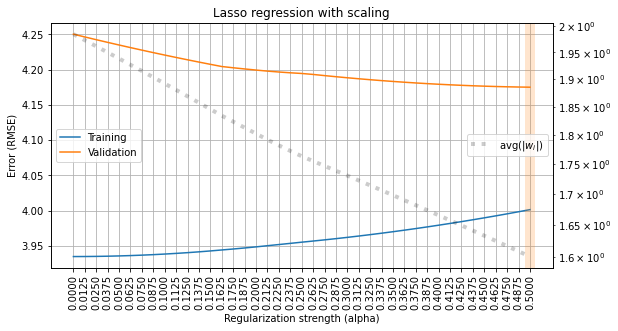

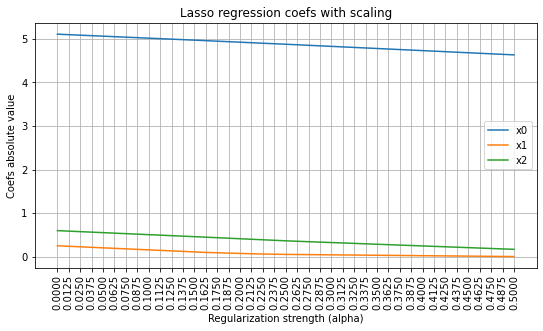

In [162]:
rmse_train_scaled, rmse_valid_scaled, coefs_scaled, avg_coef_scaled = [], [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha, scale=True), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    
    
    rmse_train_scaled.append(-np.mean(results['train_score']))
    rmse_valid_scaled.append(-np.mean(results['test_score']))
    avg_coef_scaled.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
    # average weight over cv folds for each feature
    n_features = results['estimator'][-1]['pol'].n_output_features_
    coefs_scaled.append([np.mean([np.abs(model['reg'].coef_[i]) for model in results['estimator']]) for i in range(n_features)])
    
plot_fitting_graph(ALPHAS, rmse_train_scaled, rmse_valid_scaled,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_scaled, custom_label='avg(|$w_i$|)',
                   title='Lasso regression with scaling')

coefs_scaled = np.array(coefs_scaled)
columns = results['estimator'][-1]['pol'].get_feature_names_out()
coefs_scaled_df = pd.DataFrame(coefs_scaled, columns=columns, index=ALPHAS)
coefs_scaled_df.index.name = 'alpha'                 
plot_weights_for_each_feature(ALPHAS, coefs_scaled_df, 
                                  xlabel='Regularization strength (alpha)', ylabel='Coefs absolute value', 
                                  title='Lasso regression coefs with scaling')

In [163]:
coefs_scaled_df

,x0,x1,x2
alpha,,,
0.0000,5.106884,0.249688,0.597729
0.0125,5.095449,0.237980,0.586172
0.0250,5.084014,0.226272,0.574615
0.0375,5.072579,0.214563,0.563058
0.0500,5.061144,0.202855,0.551501
0.0625,5.049709,0.191146,0.539943
0.0750,5.038274,0.179438,0.528386
0.0875,5.026839,0.167730,0.516829
0.1000,5.015404,0.156021,0.505272


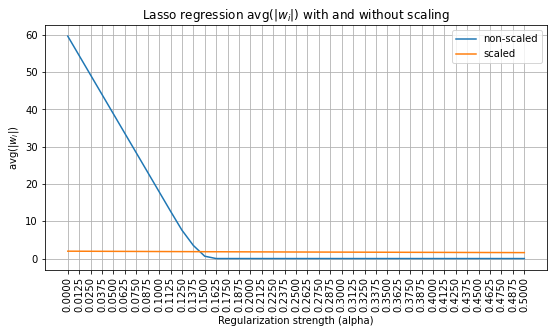

In [164]:
plot_weights(ALPHAS, avg_coef, avg_coef_scaled,
                   label_1='non-scaled', label_2='scaled',
                   xlabel='Regularization strength (alpha)', ylabel='avg(|$w_i$|)',
                   title='Lasso regression avg(|$w_i$|) with and without scaling')

Now we see more reasonable behaviour of train and test errors and smoother change in weights. All weights initially lay in similar ranges and get smaller with bigger alphas.

#### L2

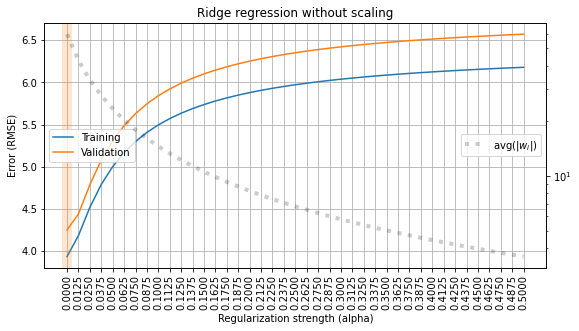

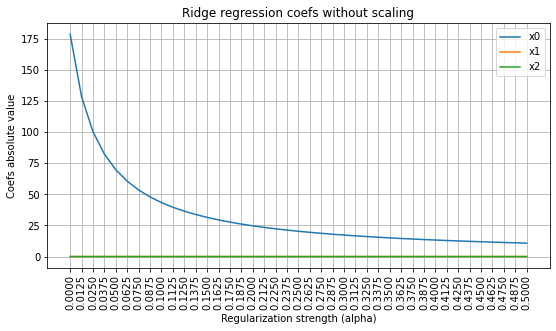

In [165]:
rmse_train, rmse_valid, coefs, avg_coef = [], [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha, scale=False), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    
    
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
    # average weight over cv folds for each feature
    n_features = results['estimator'][-1]['pol'].n_output_features_
    coefs.append([np.mean([np.abs(model['reg'].coef_[i]) for model in results['estimator']]) for i in range(n_features)])
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge regression without scaling')

coefs = np.array(coefs)
columns = results['estimator'][-1]['pol'].get_feature_names_out()
coefs_df = pd.DataFrame(coefs, columns=columns, index=ALPHAS)
coefs_df.index.name = 'alpha'                 
plot_weights_for_each_feature(ALPHAS, coefs_df, 
                                  xlabel='Regularization strength (alpha)', ylabel='Coefs absolute value', 
                                  title='Ridge regression coefs without scaling')

We see the same picture: weights of first feature significantly differ from other weights at the very beginning due to different scales.  
Let's have a closer look to change in weights of second and third features: 

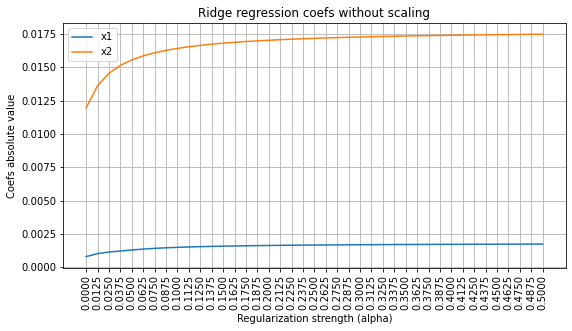

In [166]:
plot_weights_for_each_feature(ALPHAS, coefs_df.iloc[:, 1:], 
                                  xlabel='Regularization strength (alpha)', ylabel='Coefs absolute value', 
                                  title='Ridge regression coefs without scaling')

The same as with the Lasso without scaling.

Scaled input features:

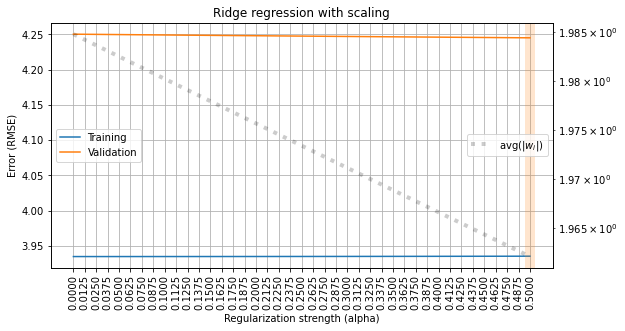

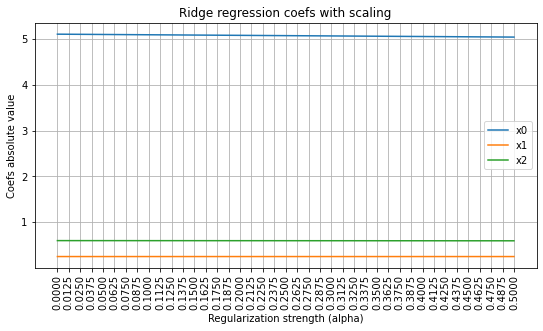

In [167]:
rmse_train_scaled, rmse_valid_scaled, coefs_scaled, avg_coef_scaled = [], [], [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha, scale=True), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    
    
    rmse_train_scaled.append(-np.mean(results['train_score']))
    rmse_valid_scaled.append(-np.mean(results['test_score']))
    avg_coef_scaled.append(np.mean([np.mean(np.abs(model['reg'].coef_)) for model in results['estimator']]))
    
    # average weight over cv folds for each feature
    n_features = results['estimator'][-1]['pol'].n_output_features_
    coefs_scaled.append([np.mean([np.abs(model['reg'].coef_[i]) for model in results['estimator']]) for i in range(n_features)])
    
plot_fitting_graph(ALPHAS, rmse_train_scaled, rmse_valid_scaled,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_scaled, custom_label='avg(|$w_i$|)',
                   title='Ridge regression with scaling')

coefs_scaled = np.array(coefs_scaled)
columns = results['estimator'][-1]['pol'].get_feature_names_out()
coefs_scaled_df = pd.DataFrame(coefs_scaled, columns=columns, index=ALPHAS)
coefs_scaled_df.index.name = 'alpha'                 
plot_weights_for_each_feature(ALPHAS, coefs_scaled_df, 
                                  xlabel='Regularization strength (alpha)', ylabel='Coefs absolute value', 
                                  title='Ridge regression coefs with scaling')

In [168]:
coefs_scaled_df

,x0,x1,x2
alpha,,,
0.0000,5.106884,0.249688,0.597729
0.0125,5.105272,0.249685,0.597628
0.0250,5.103661,0.249682,0.597528
0.0375,5.102051,0.249679,0.597427
0.0500,5.100442,0.249676,0.597326
0.0625,5.098834,0.249673,0.597225
0.0750,5.097227,0.249669,0.597125
0.0875,5.095621,0.249666,0.597024
0.1000,5.094016,0.249663,0.596923


Coefficients have almost zero changes, but still become a little smaller with the growth of alpha.

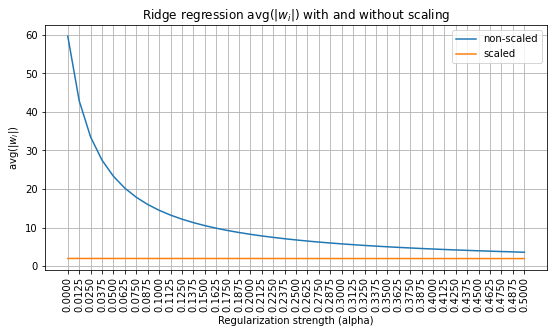

In [169]:
plot_weights(ALPHAS, avg_coef, avg_coef_scaled,
                   label_1='non-scaled', label_2='scaled',
                   xlabel='Regularization strength (alpha)', ylabel='avg(|$w_i$|)',
                   title='Ridge regression avg(|$w_i$|) with and without scaling')

#### Summary



In our example preliminary standartization didn't significantly affect quality of our model, but it is important, because Lasso and Ridge regression put constraints on the weights associated with each feature and these weights depend on their scale. If predictor variables have different scales then they will have different contributions to the target. L1/L2 penalize larger coefficient more and shrinking will not be fair anymore.